In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import gc
import os
import math
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn import metrics
from sklearn import model_selection
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

import cv2
import albumentations as A

import tensorflow as tf
import tensorflow.keras.backend as K
import efficientnet.tfkeras as efn
print("Tensorflow version =", tf.__version__)

Tensorflow version = 2.3.0


## Initialize environment

In [4]:
DATA_PATH = Path("../input"); print("Data path at", DATA_PATH)
LOG_PATH = Path("../logs"); print("Log path at", LOG_PATH)
MODEL_PATH = Path("../models"); print("Model path at", MODEL_PATH)

Data path at ../input
Log path at ../logs
Model path at ../models


In [5]:
# CONFIGURE GPUs
gpus = tf.config.list_physical_devices("GPU"); print(gpus)
if len(gpus) == 1: strategy = tf.distribute.OneDeviceStrategy(device="/gpu:0")
else: strategy = tf.distribute.MirroredStrategy()

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [6]:
# ENABLE MIXED PRECISION for speed
tf.config.optimizer.set_experimental_options({"auto_mixed_precision": True})
print("Mixed precision enabled")

Mixed precision enabled


In [7]:
# VERSION MAJOR and MINOR for loggins
mm = 1; rr = 0

# BEGIN LOG FILE
with open(LOG_PATH / f"log-{mm}-{rr}.txt", "a") as f:
    print(f'Logging to "log-{mm}-{rr}.txt"')
    f.write('#############################\n')
    f.write(f"Trial mm={mm}, rr={rr}\n")
    f.write("efNetB4, batch_size=512, seed=42, 64x64, fold=0, LR 1e-3 with 0.75 decay\n")
    f.write('#############################\n')
    
BATCH_SIZE = 128
DIM = 64

Logging to "log-1-0.txt"


## STEP 1: Preprocess

In [8]:
# %%time
# train = []
# # for x in [0, 1, 2, 3]:
# for x in [0]:
#     f = f"train_image_data_{x}.parquet"
#     print(f, end="")
#     df = pd.read_parquet(DATA_PATH / f)
#     img = df.iloc[:, 1:].values.reshape(-1, 137, 236, 1)
#     img2 = np.zeros((img.shape[0], DIM, DIM, 1), dtype="float32")
#     for j in range(len(img)):
#         img2[j,:,:,0] = cv2.resize(img[j], (DIM, DIM), interpolation=cv2.INTER_AREA)
#         if j % 1000 == 0: print(j, ", ", end="")
#     print()
#     img2 = (255 - img2) / 255.0
#     train.append(img2)

In [9]:
# x_train = np.concatenate(train)
# print("Train shape", x_train.shape)

In [10]:
# np.save(DATA_PATH/"fold0-x_train", x_train)
x_train = np.load(DATA_PATH/"fold0-x_train.npy")

In [11]:
# del img, img2, train
# _ = gc.collect()

### Preprocess - EDA

In [12]:
train = pd.read_csv(DATA_PATH/"train.csv")
y_train = train.iloc[:, 1:4].values[:len(x_train)]

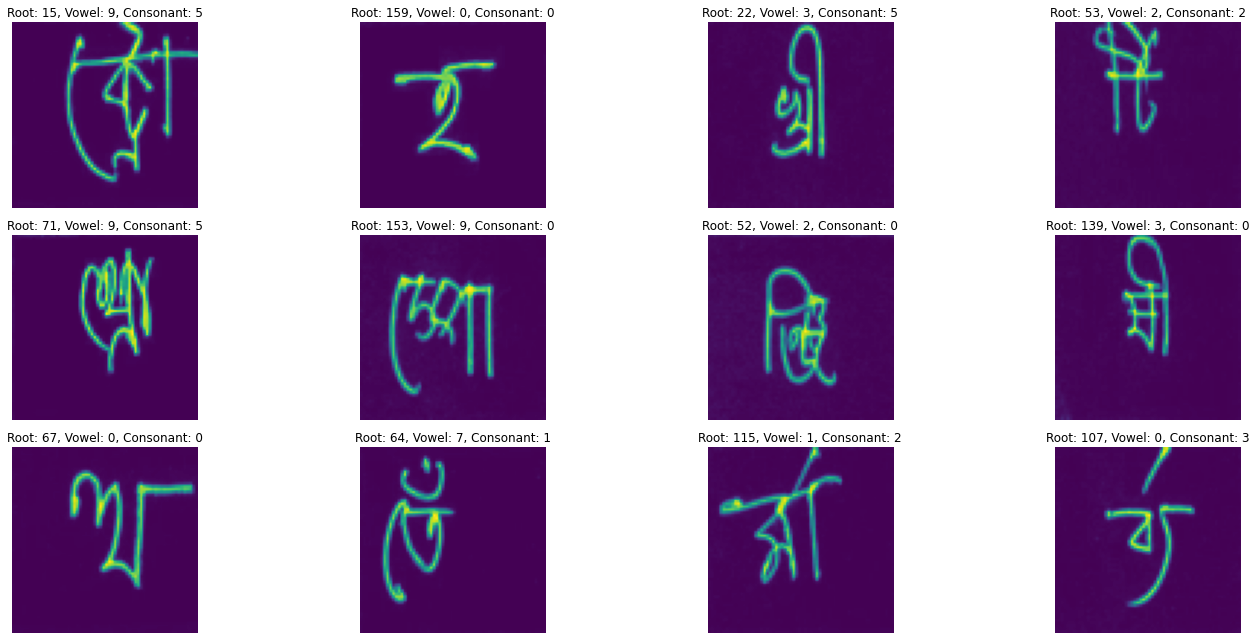

In [13]:
rows = 3; cols = 4
fig, axes = plt.subplots(rows, cols, figsize=(20, (rows/cols) * 12))
axes = axes.flatten()
for i, ax in enumerate(axes):
#     ax.imshow(x_train[i,:,:,0], cmap=plt.cm.binary)
    ax.imshow(x_train[i,:,:,0])
    root, vowel, consonant = y_train[i]
    ax.set_title(f"Root: {root}, Vowel: {vowel}, Consonant: {consonant}")
    ax.axis("off")
plt.tight_layout()

## STEP 2: Data Augmentation

In [14]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(
        self, x, y, list_IDs, batch_size=BATCH_SIZE, shuffle=False,
        augment=False, labels=True, cutmix=False, yellow=False
    ):
        self.x = x
        self.y = y
        self.augment = augment
        self.list_IDs = list_IDs
        self.shuffle = shuffle
        self.batch_size = batch_size
        self.labels = labels
        self.cutmix = cutmix
        self.yellow = yellow
        self.on_epoch_end()
    
    def __len__(self):
        "Number of batches per epoch"
        return math.ceil(len(self.list_IDs) / self.batch_size)
    
    def __getitem__(self, index):
        "Gets batch at position `index`"
        indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]
        x, y = self.__data_generation(indices)
        if self.augment:
            x = self.__augment_batch(x)
        if self.labels:
            return x, [y[:,:168], y[:, 168:179], y[:, 179:]]
        else:
            return x
    
    def on_epoch_end(self):
        self.indices = np.arange(len(self.list_IDs))
        if self.shuffle:
            np.random.shuffle(self.indices)
            
    def __data_generation(self, indices):
        "Generates data containing `batch_size` samples"
        x = self.x[self.list_IDs[indices]]
        if self.yellow:
            x = np.ones((len(indices), DIM, DIM, 1))
            
        y = np.zeros((len(indices), 186))
        for j in range(len(indices)):
            idx = self.list_IDs[indices[j]]
            y[j, self.y[idx, 0]] = 1
            y[j, 168 + self.y[idx, 1]] = 1
            y[j, 179 + self.y[idx, 2]] = 1
            
        if self.cutmix:
            for j in range(len(indices)):
                # CHOOSE RANDOM CENTER
                yy = np.random.randint(DIM)
                xx = np.random.randint(DIM)
                z = np.random.choice(self.list_IDs)

                # CHOOSE RANDOM WIDTH AND HEIGHT
                h = np.random.randint(DIM//2-DIM//16, DIM//2+DIM//16)
                w = np.random.randint(DIM//2-DIM//16, DIM//2+DIM//16)

                # CUTMIX IMAGES
                ya = np.clip(yy - h//2, 0, DIM)
                yb = np.clip(yy + h//2, 0, DIM)
                xa = np.clip(xx - w//2, 0, DIM)
                xb = np.clip(xx + w//2, 0, DIM)
                x[j, ya:yb, xa:xb, 0] = self.x[z, ya:yb, xa:xb, 0]

                # CUTMIX LABELS
                r = (yb-ya)*(xb-xa)/DIM/DIM
                y2 = np.zeros((1, 186))
                y2[0, self.y[z, 0]] = 1
                y2[0, 168 + self.y[z, 1]] = 1
                y2[0, 179 + self.y[z, 2]] = 1
                y[j] = (1 - r) * y[j] + r * y2[0]
            
        return x, y
        
    def __random_transform(self, img):
        augs = A.Compose([
            A.ShiftScaleRotate(rotate_limit=8, scale_limit=0.16, shift_limit=0, border_mode=0, value=0, p=0.5),
            A.CoarseDropout(max_holes=16, max_height=DIM//10, max_width=DIM//10, fill_value=0, p=0.5),
            A.ShiftScaleRotate(rotate_limit=0, scale_limit=0, shift_limit=0.12, border_mode=0, value=0, p=0.5),
        ])
        return augs(image=img)["image"]
    
    def __augment_batch(self, img_batch):
        for i in range(len(img_batch)):
            img_batch[i] = self.__random_transform(img_batch[i])
        return img_batch

### Data Augmentation - EDA

Cutmix Augmentation with first image displayed as all yellow


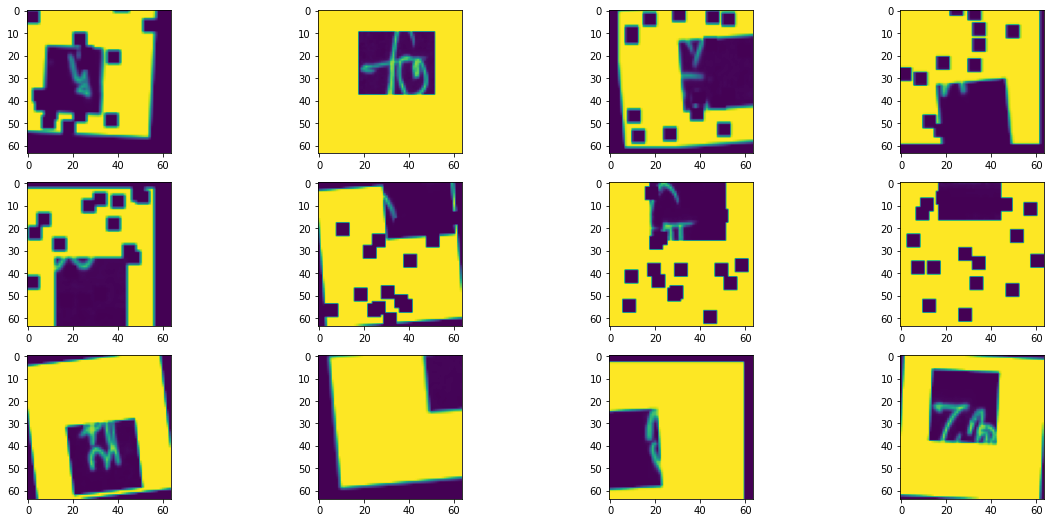

In [15]:
print("Cutmix Augmentation with first image displayed as all yellow")
gen = DataGenerator(
    x_train, y_train, list_IDs=np.arange(len(x_train)),
    batch_size=BATCH_SIZE,cutmix=True, shuffle=True, augment=True, yellow=True)

rows=3; cols=4;
fig, axes = plt.subplots(rows, cols, figsize=(20, (rows/cols)*12))
axes = axes.flatten()

for batch in gen:
    for i, ax in enumerate(axes):
        ax.imshow(batch[0][i,:,:,0])
    break

## STEP 3: Build Model

In [16]:
def get_model():
    inp = tf.keras.Input(shape=(DIM, DIM, 1))
    inp2 = tf.keras.layers.Concatenate()([inp, inp, inp])
    base_model = efn.EfficientNetB4(weights=None, include_top=False, input_shape=(DIM, DIM, 3))
    base_model.load_weights(MODEL_PATH/"efnB4.h5")
    
    x = base_model(inp2)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x1 = tf.keras.layers.Dense(168, activation="softmax", name="x1", dtype="float32")(x)
    x2 = tf.keras.layers.Dense(11, activation="softmax", name="x2", dtype="float32")(x)
    x3 = tf.keras.layers.Dense(7, activation="softmax", name="x3", dtype="float32")(x)
    
    model = tf.keras.Model(inputs=inp, outputs=[x1, x2, x3])
    
    optimizer = tf.keras.optimizers.Adam(lr=0.00001)
    wgt = {"x1": 1.5, "x2": 1.0, "x3": 1.0}
    
    model.compile(
        loss="categorical_crossentropy",
        optimizer=optimizer,
        metrics=["categorical_accuracy"],
        loss_weights=wgt
    )
    
    return model

### Validation Metric and Logging

Competition metric is macro recall

In [17]:
class CustomCallback(tf.keras.callbacks.Callback):
    def __init__(self, valid_data, target, fold, mm=0, rr=0, patience=10):
        self.valid_inputs = valid_data
        self.valid_outputs = target
        self.fold = fold
        self.patience = patience
        self.mm = mm 
        self.rr = rr
    
    def on_train_begin(self, logs={}):
        "Called at the beginning of training"
        self.valid_f1 = [0]
        self.early_stopping_counter = 0
        self.best_f1 = 0.0
    
    def on_epoch_end(self, epoch, logs={}):
        "Called at the end of an epoch"
        preds = self.model.predict(self.valid_inputs)
        preds0 = np.argmax(preds[0], axis=1)
        preds1 = np.argmax(preds[1], axis=1)
        preds2 = np.argmax(preds[2], axis=1)
        
        targ0 = self.valid_outputs[0]
        targ1 = self.valid_outputs[1]
        targ2 = self.valid_outputs[2]
        
        r0 = metrics.recall_score(targ0, preds0, average="macro")
        r1 = metrics.recall_score(targ0, preds0, average="macro")
        r2 = metrics.recall_score(targ0, preds0, average="macro")
        
        a0 = metrics.accuracy_score(targ0, preds0)
        a1 = metrics.accuracy_score(targ1, preds1)
        a2 = metrics.accuracy_score(targ2, preds2)
        
        f1 = 0.5*r0 + 0.25*r1 + 0.25*r2
        
        # LOG TO FILE
        with open(LOG_PATH/f"log-{self.mm}-{self.rr}.txt", "a") as f:
            f.write("#"*25); f.write("\n")
            f.write(f"#### FOLD {self.fold} EPOCH {epoch}\n")
            f.write(f"#### ACCURACY: a0={a0:.5f}, a1={a1:.5f}, a2={a2:.5f}")
            f.write(f"#### MACRO RECALL: r0={r0:.5f}, r1={r1:.5f}, r2={r2:.5f}")
            f.write(f"#### CV/LB: {f1:.5f}")
            
            print(); print("#"*25)
            print(f"#### FOLD {self.fold} EPOCH {epoch}\n")
            print(f"#### ACCURACY: a0={a0:.5f}, a1={a1:.5f}, a2={a2:.5f}")
            print(f"#### MACRO RECALL: r0={r0:.5f}, r1={r1:.5f}, r2={r2:.5f}")
            print(f"#### CV/LB: {f1:.5f}")
            print("#"*25)
            
            self.valid_f1.append(f1)
            
            if f1 > self.best_f1:
                print("#### Saving new best...")
                f.write("#### Saving new best...\n")
                self.model.save_weights(MODEL_PATH/f"fold{self.fold}-m{self.mm}-{self.rr}.h5")
                self.best_f1 = f1
                self.early_stopping_counter = 0
            else:
                self.early_stopping_counter += 1
            
            if self.early_stopping_counter >= self.patience:
                print(f"#### CV/LB no increase for {self.patience} epochs: EARLY STOPPING")
                f.write(f"#### CV/LB no increase for {self.patience} epochs: EARLY STOPPING\n")
                self.model.stop_training = True

## STEP 4: Training Schedule

Learning rate schedule: 1e-05 to 0.001 to 7.51e-05


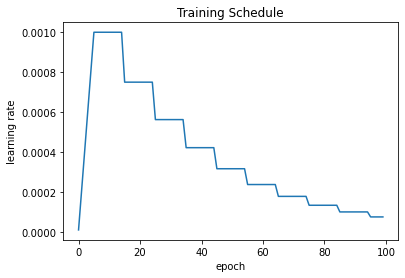

In [18]:
# CUSTOM LEARNING RATE SCHEDULE
LR_START = 1e-5
LR_MAX = 1e-3
LR_RAMPUP_EPOCHS = 5
LR_SUSTAIN_EPOCHS = 0
LR_STEP_DECAY = 0.75

def lr_fn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = LR_MAX * LR_STEP_DECAY ** ((epoch - LR_SUSTAIN_EPOCHS - LR_RAMPUP_EPOCHS) // 10)
    return lr

lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_fn, verbose=True)

rng = np.arange(100)
y = [lr_fn(x) for x in rng]
plt.plot(rng, y)
plt.xlabel("epoch"); plt.ylabel("learning rate");
plt.title("Training Schedule");
print(f"Learning rate schedule: {y[0]:.3g} to {max(y):.3g} to {y[-1]:.3g}")

### Train Model

When validation score doesn't increase for 15 epochs, we stop training to save time.

In [26]:
oof0 = np.zeros((len(x_train), 168))
oof1 = np.zeros((len(x_train), 11))
oof2 = np.zeros((len(x_train), 7))

kf = MultilabelStratifiedKFold(n_splits=5, random_state=True)
for fold, (train_idx, valid_idx) in enumerate(kf.split(x_train, y_train)):
    print("#"*25)
    print(f"### FOLD {fold}")
    print(f"### Train on {len(train_idx)} images. Validate on {len(valid_idx)} images.")
    print("#"*25)
    
    K.clear_session()
    with strategy.scope():
        model = get_model()
        
    train_gen = DataGenerator(x_train, y_train, train_idx, shuffle=True, augment=True, cutmix=True, batch_size=BATCH_SIZE)
    val_x = DataGenerator(x_train, y_train, valid_idx, labels=False, batch_size=4*BATCH_SIZE)
    val_y = [y_train[valid_idx, 0], y_train[valid_idx, 1], y_train[valid_idx, 2]]
    
    cc = CustomCallback(valid_data=val_x, target=val_y, fold=fold, mm=mm, rr=rr, patience=15)
    history = model.fit(train_gen, epochs=150, verbose=1, callbacks=[cc, lr_callback])
    
    print("#### Loading best weights...")
    model.load_weights(MODEL_PATH/f"fold{fold}-m{mm}-{rr}.h5")
    
    val_x = DataGenerator(x_train, y_train, valid_idx, batch_size=4*BATCH_SIZE)
    oo = model.predict(val_x)
    oof0[valid_idx] = oo[0]
    oof1[valid_idx] = oo[1]
    oof2[valid_idx] = oo[2]
    
    # SAVE OOF and VALID_IDX
    np.save(DATA_PATH/f"processed/oof0-{mm}-{rr}", oof0)
    np.save(DATA_PATH/f"processed/oof1-{mm}-{rr}", oof1)
    np.save(DATA_PATH/f"processed/oof2-{mm}-{rr}", oof2)
    np.save(DATA_PATH/f"processed/valid_idx-{mm}-{rr}", valid_idx)
    np.save(DATA_PATH/f"processed/y_train-{mm}-{rr}", y_train)
    break

#########################
### FOLD 0
### Train on 40168 images. Validate on 10042 images.
#########################

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 1/150
314/314 [==============================] - ETA: 0s - loss: 12.2867 - x1_loss: 5.2367 - x2_loss: 2.4803 - x3_loss: 1.9513 - x1_categorical_accuracy: 0.0074 - x2_categorical_accuracy: 0.1082 - x3_categorical_accuracy: 0.1981
#########################
#### FOLD 0 EPOCH 0

#### ACCURACY: a0=0.00498, a1=0.10137, a2=0.17347
#### MACRO RECALL: r0=0.00669, r1=0.00669, r2=0.00669
#### CV/LB: 0.00669
#########################
#### Saving new best...
314/314 [==============================] - 28s 90ms/step - loss: 12.2867 - x1_loss: 5.2367 - x2_loss: 2.4803 - x3_loss: 1.9513 - x1_categorical_accuracy: 0.0074 - x2_categorical_accuracy: 0.1082 - x3_categorical_accuracy: 0.1981

Epoch 00002: LearningRateScheduler reducing learning rate to 0.000208.
Epoch 2/150
314/314 [==============================] - ETA

## STEP 5: Post-process

In [28]:
oo = model.predict(val_x, verbose=1)
oof0[valid_idx] = oo[0]
oof1[valid_idx] = oo[1]
oof2[valid_idx] = oo[2]

20/20 [==============================] - 1s 70ms/step


In [29]:
oof0b = np.argmax(oof0[valid_idx], axis=1)
oof1b = np.argmax(oof1[valid_idx], axis=1)
oof2b = np.argmax(oof2[valid_idx], axis=1)

r0 = metrics.recall_score(y_train[valid_idx, 0], oof0b, average="macro")
r1 = metrics.recall_score(y_train[valid_idx, 1], oof1b, average="macro")
r2 = metrics.recall_score(y_train[valid_idx, 2], oof2b, average="macro")
r = 0.5*r0 + 0.25*r1 + 0.25*r2
print(f"CV/LB without post-processing {r:.5f}")

CV/LB without post-processing 0.95886


In [34]:
EXP = -0.9

s0 = pd.Series(oof0b)
vc0 = s0.value_counts().sort_index()
mat0 = np.diag(vc0.astype("float32") ** EXP) 

s1 = pd.Series(oof1b)
vc1 = s1.value_counts().sort_index()
mat1 = np.diag(vc1.astype("float32") ** EXP)

s2 = pd.Series(oof2b)
vc2 = s2.value_counts().sort_index()
mat2 = np.diag(vc2.astype("float32") ** EXP)

In [35]:
oof0b = np.argmax(oof0[valid_idx].dot(mat0), axis=1)
oof1b = np.argmax(oof1[valid_idx].dot(mat1), axis=1)
oof2b = np.argmax(oof2[valid_idx].dot(mat2), axis=1)

r0 = metrics.recall_score(y_train[valid_idx, 0], oof0b, average="macro")
r1 = metrics.recall_score(y_train[valid_idx, 1], oof1b, average="macro")
r2 = metrics.recall_score(y_train[valid_idx, 2], oof2b, average="macro")
r = 0.5*r0 + 0.25*r1 + 0.25*r2
print(f"CV/LB with post-processing {r:.5f}")

CV/LB with post-processing 0.96675


### Predict Test and Submit

In [19]:
def get_test(x):
    path = DATA_PATH/f"test_image_data_{x}.parquet"
    imgs = pd.read_parquet(path)
    imgs = imgs.iloc[:,1:].values.reshape((-1, 137, 236, 1))
    imgs2 = np.zeros((len(imgs), DIM, DIM, 1), dtype="float32")
    for j in range(len(imgs)):
        imgs2[j,:,:,0] = cv2.resize(imgs[j], (DIM, DIM), interpolation=cv2.INTER_AREA)
    imgs2 = (255 - imgs2) / 255.
    return imgs2

In [28]:
EXP = -0.9
fold = 0
# del x_train; gc.collect()

# LOAD BEST MODEL
with strategy.scope():
    model = get_model()
model.load_weights(MODEL_PATH/f"fold{fold}-m{mm}-{rr}.h5")

# PREDICT TEST
preds0 = []; preds1 = []; preds2 = []
for x in [0,1,2,3]:
    preds = model.predict(get_test(x), verbose=1)
    preds0.extend(preds[0])
    preds1.extend(preds[1])
    preds2.extend(preds[2])

preds0 = np.array(preds0)
preds1 = np.array(preds1)
preds2 = np.array(preds2)

pred0 = np.argmax(preds0, axis=1)
pred1 = np.argmax(preds1, axis=1)
pred2 = np.argmax(preds2, axis=1)

# APPLY POST-PROCESS
s = pd.Series(pred0)
vc = s.value_counts().sort_index()
df = pd.DataFrame({"a": np.arange(168), "b": np.ones(168)})
df.b = df.a.map(vc); df.fillna(df.b.min(), inplace=True)
mat0 = np.diag(df.b.astype("float32") ** EXP)

s = pd.Series(pred1)
vc = s.value_counts().sort_index()
df = pd.DataFrame({"a": np.arange(11), "b": np.ones(11)})
df.b = df.a.map(vc); df.fillna(df.b.min(), inplace=True)
mat1 = np.diag(df.b.astype("float32") ** EXP)

s = pd.Series(pred2)
vc = s.value_counts().sort_index()
df = pd.DataFrame({"a": np.arange(7), "b": np.ones(7)})
df.b = df.a.map(vc); df.fillna(df.b.min(), inplace=True)
mat2 = np.diag(df.b.astype("float32") ** EXP)

# POST-PROCESS
pred0 = np.argmax(preds0.dot(mat0), axis=1)
pred1 = np.argmax(preds1.dot(mat1), axis=1)
pred2 = np.argmax(preds2.dot(mat2), axis=1)

1/1 [==============================] - 0s 1ms/step


### Write Submission CSV

In [29]:
row_id = []; target = []
for i in range(len(pred0)):
    row_id += [f"Test_{i}_grapheme_root", f"Test_{i}_vowel_diacritic", f"Test_{i}_consonant_diacritic"]
    target += [pred0[i], pred1[i], pred2[i]]
subm = pd.DataFrame({"row_id": row_id, "target": target})
subm.to_csv("../output/submission.csv", index=False)
subm.head()

,row_id,target
0,Test_0_grapheme_root,3
1,Test_0_vowel_diacritic,0
2,Test_0_consonant_diacritic,0
3,Test_1_grapheme_root,93
4,Test_1_vowel_diacritic,2
